In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## CUDA available?

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Downloading MNIST dataset

In [3]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # we take only 64 images at a time because of the amount of ROM available. Typically we take a power of 2.
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

## The Neural Network

In [4]:
class FlexibleNetwork(nn.Module):
    def __init__(self, layer_sizes, dropout_rate=0.5):
        super(FlexibleNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Create layers based on the provided layer sizes
        input_size = 28 * 28  # assuming input is a flattened 28x28 image
        for output_size in layer_sizes:
            self.layers.append(nn.Linear(input_size, output_size))
            input_size = output_size
        self.output_layer = nn.Linear(input_size, 10)  # output layer for 10 classes
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # flatten input
        for i, layer in enumerate(self.layers):
            x = self.relu(layer(x))
            # Apply dropout only after the first layer
            if i == 0:
                x = self.dropout(x)
        x = self.output_layer(x)
        return x

## Training Function

In [5]:
def train_model(label='Training', layer_sizes=None, dropout_rate=0.5, optimizer_type='Adam', reg_type='None', reg_lambda=0.0, momentum=None, n_epochs=5):
    model = FlexibleNetwork(layer_sizes, dropout_rate=dropout_rate)
    criterion = nn.CrossEntropyLoss()

    # Add optimizer if specified
    if optimizer_type == 'SGD':
        if momentum is not None and momentum > 0:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD without momentum
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = None

    train_losses = []
    test_losses = []

    print(f"\nExperiment: {label}")
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader: # loop over each batch
            if optimizer is not None:
                optimizer.zero_grad() # zero the parameter gradients
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Apply regularization if specified
            if reg_type == 'L1':
                l1_norm = sum(param.abs().sum() for param in model.parameters()) # L1 norm of all parameters
                loss += reg_lambda * l1_norm # add L1 regularization to loss
            elif reg_type == 'L2':
                l2_norm = sum(param.pow(2).sum() for param in model.parameters()) # L2 norm of all parameters
                loss += reg_lambda * l2_norm # add L2 regularization to loss

            loss.backward() # Compute gradients
            if optimizer is not None:
                optimizer.step() # update weights
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Evaluation on test set
        model.eval() # switch to evaluation mode
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad(): # disable gradient calculation for efficiency
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        accuracy = 100 * correct / total

        # Print statistics
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_loss:.4f} | Test Loss: {test_loss:.4f} | Accuracy: {accuracy:.2f}%")
    
    return train_losses, test_losses

## Default config

In [6]:
# Define the default configuration
default_config = {
    "layer_sizes": [128, 64],
    "dropout_rate": 0.0,
    "optimizer_type": "Adam",
    "reg_type": "None",
    "reg_lambda": 0.001,
    "momentum": None,
    "n_epochs": 5,
    "label": "Default Experiment"
}

## Result handler

In [7]:
def result_handler(experiment_configs):
    results = {}
    for config in experiment_configs:
        label = config["label"]
        train_losses, test_losses = train_model(
            label=label,
            layer_sizes=config["layer_sizes"],
            dropout_rate=config["dropout_rate"],
            optimizer_type=config["optimizer_type"],
            reg_type=config["reg_type"],
            reg_lambda=config["reg_lambda"],
            momentum=config["momentum"],
            n_epochs=config["n_epochs"]
        )
        results[label] = {"train_losses": train_losses, "test_losses": test_losses}
    return results

## Plot handler

In [8]:
def plot_handler(results, experiment_configs):
    num_experiments = len(experiment_configs)
    fig, axs = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5), sharey=True)
    epochs = range(1, default_config["n_epochs"] + 1)
    for i, (label, data) in enumerate(results.items()):
        axs[i].plot(epochs, data["train_losses"], marker='o', label="Train Loss")
        axs[i].plot(epochs, data["test_losses"], marker='o', linestyle='--', label="Test Loss")
        axs[i].set_title(label)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

## 1. Regularization


Experiment: Default
Epoch 1/5 | Train Loss: 0.2456 | Test Loss: 0.1568 | Accuracy: 95.21%
Epoch 2/5 | Train Loss: 0.1423 | Test Loss: 0.1317 | Accuracy: 96.33%
Epoch 3/5 | Train Loss: 0.1189 | Test Loss: 0.1380 | Accuracy: 96.46%
Epoch 4/5 | Train Loss: 0.1098 | Test Loss: 0.1482 | Accuracy: 96.43%
Epoch 5/5 | Train Loss: 0.1059 | Test Loss: 0.1532 | Accuracy: 96.66%

Experiment: L1(0.003)
Epoch 1/5 | Train Loss: 1.7979 | Test Loss: 0.7964 | Accuracy: 73.71%
Epoch 2/5 | Train Loss: 1.5420 | Test Loss: 0.7399 | Accuracy: 77.55%
Epoch 3/5 | Train Loss: 1.4894 | Test Loss: 0.7916 | Accuracy: 73.54%
Epoch 4/5 | Train Loss: 1.4621 | Test Loss: 0.7617 | Accuracy: 75.57%
Epoch 5/5 | Train Loss: 1.4513 | Test Loss: 0.7287 | Accuracy: 76.94%

Experiment: L1(0.002)
Epoch 1/5 | Train Loss: 1.3395 | Test Loss: 0.3977 | Accuracy: 87.57%
Epoch 2/5 | Train Loss: 1.1108 | Test Loss: 0.3796 | Accuracy: 88.74%
Epoch 3/5 | Train Loss: 1.0732 | Test Loss: 0.3634 | Accuracy: 89.10%
Epoch 4/5 | Train Loss:

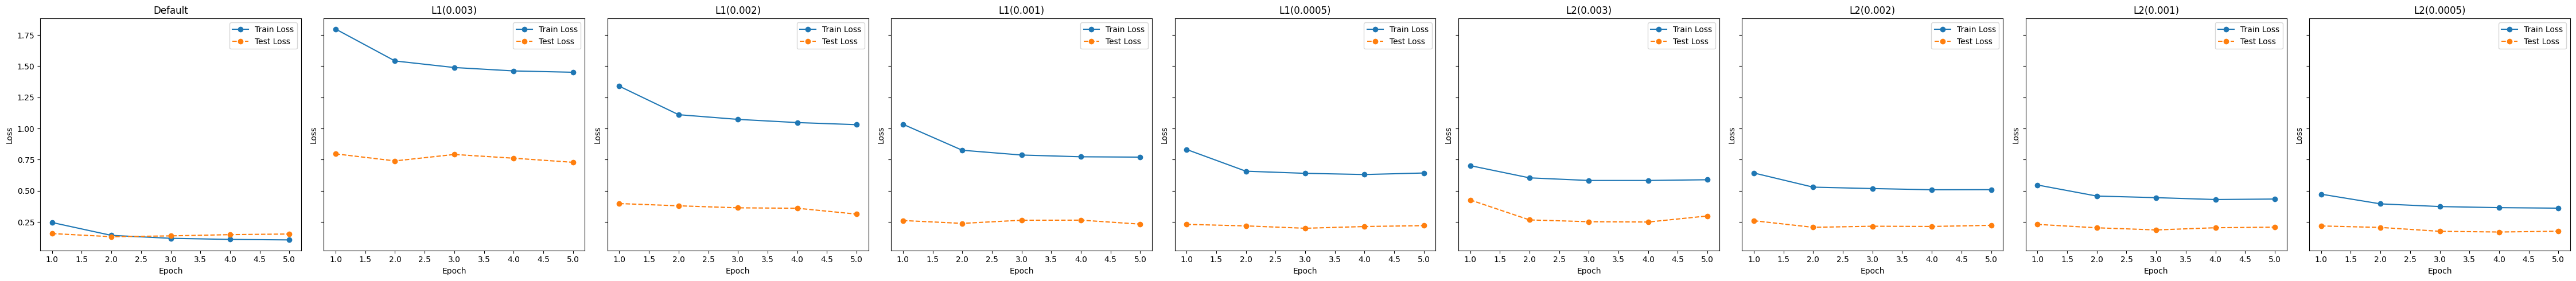

In [9]:
reg_configs = [
    {**default_config, "label": "Default"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.003, "label": "L1(0.003)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.002, "label": "L1(0.002)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.001, "label": "L1(0.001)"},
    {**default_config, "reg_type": "L1", "reg_lambda": 0.0005, "label": "L1(0.0005)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.003, "label": "L2(0.003)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.002, "label": "L2(0.002)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.001, "label": "L2(0.001)"},
    {**default_config, "reg_type": "L2", "reg_lambda": 0.0005, "label": "L2(0.0005)"},
]
reg_results = result_handler(reg_configs)
plot_handler(reg_results, reg_configs)

## 2. Dropout


Experiment: Drop(0.2)
Epoch 1/5 | Train Loss: 0.3081 | Test Loss: 0.1664 | Accuracy: 95.14%
Epoch 2/5 | Train Loss: 0.2095 | Test Loss: 0.1558 | Accuracy: 95.72%
Epoch 3/5 | Train Loss: 0.1884 | Test Loss: 0.1541 | Accuracy: 95.96%
Epoch 4/5 | Train Loss: 0.1744 | Test Loss: 0.1376 | Accuracy: 96.55%
Epoch 5/5 | Train Loss: 0.1640 | Test Loss: 0.1364 | Accuracy: 96.43%

Experiment: Drop(0.4)
Epoch 1/5 | Train Loss: 0.3955 | Test Loss: 0.1950 | Accuracy: 94.57%
Epoch 2/5 | Train Loss: 0.2878 | Test Loss: 0.1708 | Accuracy: 95.28%
Epoch 3/5 | Train Loss: 0.2610 | Test Loss: 0.1449 | Accuracy: 95.93%
Epoch 4/5 | Train Loss: 0.2491 | Test Loss: 0.1452 | Accuracy: 95.64%
Epoch 5/5 | Train Loss: 0.2360 | Test Loss: 0.1429 | Accuracy: 95.97%

Experiment: Drop(0.6)
Epoch 1/5 | Train Loss: 0.4028 | Test Loss: 0.1837 | Accuracy: 94.56%
Epoch 2/5 | Train Loss: 0.2895 | Test Loss: 0.1643 | Accuracy: 95.24%
Epoch 3/5 | Train Loss: 0.2685 | Test Loss: 0.1456 | Accuracy: 95.87%
Epoch 4/5 | Train Los

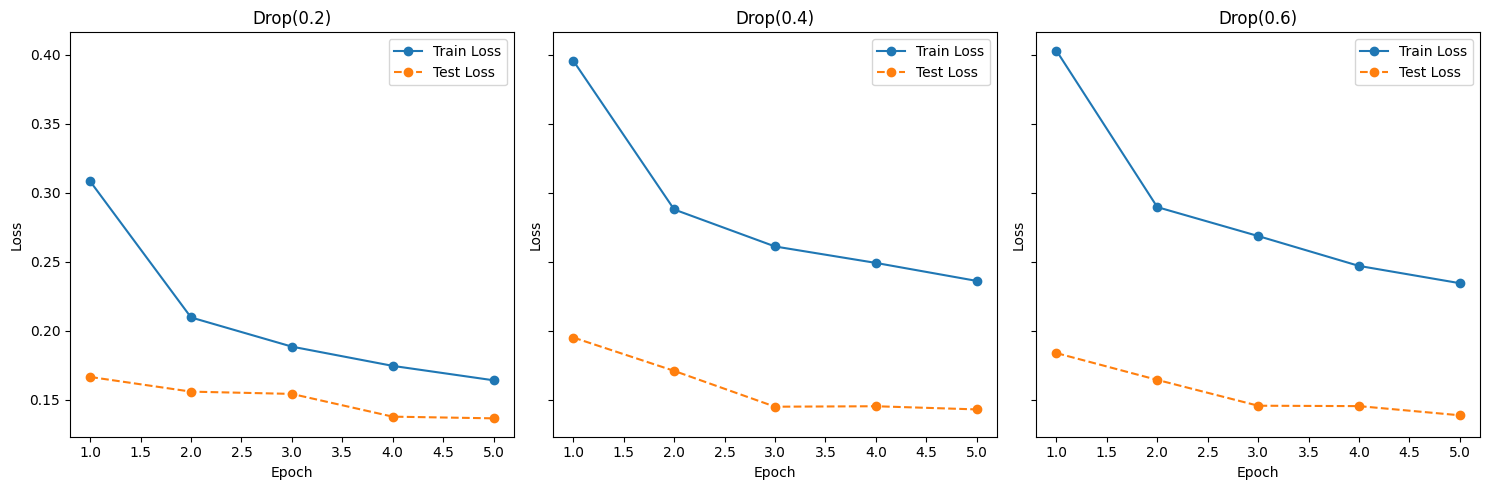

In [10]:
drop_configs = [
    {**default_config, "dropout_rate": 0.2, "label": "Drop(0.2)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.4)"},
    {**default_config, "dropout_rate": 0.4, "label": "Drop(0.6)"},
]

drop_results = result_handler(drop_configs)
plot_handler(drop_results, drop_configs)

## 3. Layers


Experiment: Small Network (64, 32)
Epoch 1/5 | Train Loss: 0.2693 | Test Loss: 0.1900 | Accuracy: 94.48%
Epoch 2/5 | Train Loss: 0.1490 | Test Loss: 0.1925 | Accuracy: 94.72%
Epoch 3/5 | Train Loss: 0.1271 | Test Loss: 0.1634 | Accuracy: 95.97%
Epoch 4/5 | Train Loss: 0.1154 | Test Loss: 0.1626 | Accuracy: 95.68%
Epoch 5/5 | Train Loss: 0.1096 | Test Loss: 0.1475 | Accuracy: 96.33%

Experiment: Medium Network (128, 64, 32)
Epoch 1/5 | Train Loss: 0.2805 | Test Loss: 0.1618 | Accuracy: 95.13%
Epoch 2/5 | Train Loss: 0.1514 | Test Loss: 0.1472 | Accuracy: 96.23%
Epoch 3/5 | Train Loss: 0.1318 | Test Loss: 0.1464 | Accuracy: 95.96%
Epoch 4/5 | Train Loss: 0.1139 | Test Loss: 0.1547 | Accuracy: 96.26%
Epoch 5/5 | Train Loss: 0.1116 | Test Loss: 0.1369 | Accuracy: 96.54%

Experiment: Large Network (256, 128, 64, 32)
Epoch 1/5 | Train Loss: 0.2978 | Test Loss: 0.1978 | Accuracy: 94.71%
Epoch 2/5 | Train Loss: 0.1634 | Test Loss: 0.1548 | Accuracy: 95.81%
Epoch 3/5 | Train Loss: 0.1367 | Tes

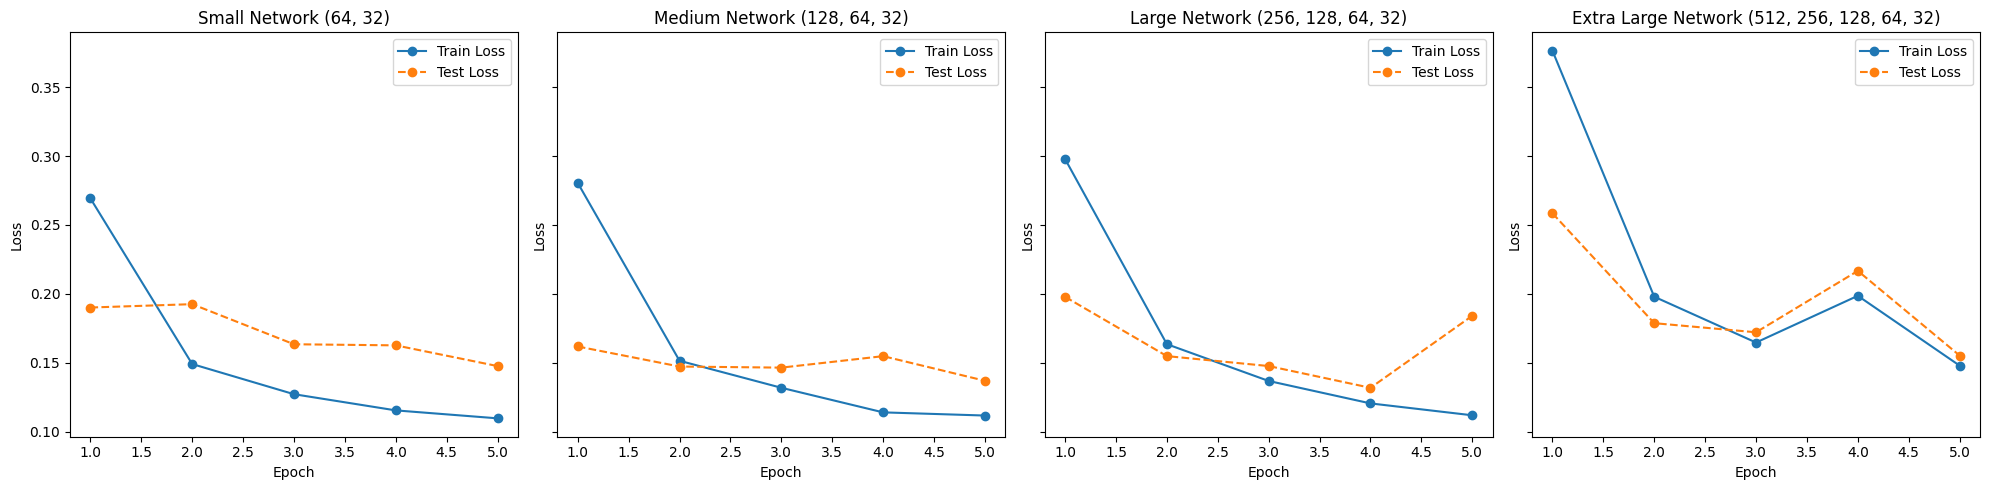

In [11]:
layer_configs = [
    {**default_config, "layer_sizes": [64, 32], "label": "Small Network (64, 32)"},
    {**default_config, "layer_sizes": [128, 64, 32], "label": "Medium Network (128, 64, 32)"},
    {**default_config, "layer_sizes": [256, 128, 64, 32], "label": "Large Network (256, 128, 64, 32)"},
    {**default_config, "layer_sizes": [512, 256, 128, 64, 32], "label": "Extra Large Network (512, 256, 128, 64, 32)"}
]

layer_results = result_handler(layer_configs)
plot_handler(layer_results, layer_configs)

## 4. Momentum


Experiment: SGD
Epoch 1/5 | Train Loss: 1.7022 | Test Loss: 0.7824 | Accuracy: 80.89%
Epoch 2/5 | Train Loss: 0.5668 | Test Loss: 0.4288 | Accuracy: 87.98%
Epoch 3/5 | Train Loss: 0.4043 | Test Loss: 0.3579 | Accuracy: 89.76%
Epoch 4/5 | Train Loss: 0.3515 | Test Loss: 0.3239 | Accuracy: 90.68%
Epoch 5/5 | Train Loss: 0.3209 | Test Loss: 0.2950 | Accuracy: 91.52%

Experiment: SGD(0.3)
Epoch 1/5 | Train Loss: 1.4697 | Test Loss: 0.5446 | Accuracy: 85.78%
Epoch 2/5 | Train Loss: 0.4381 | Test Loss: 0.3571 | Accuracy: 89.70%
Epoch 3/5 | Train Loss: 0.3485 | Test Loss: 0.3097 | Accuracy: 90.92%
Epoch 4/5 | Train Loss: 0.3086 | Test Loss: 0.2817 | Accuracy: 91.72%
Epoch 5/5 | Train Loss: 0.2803 | Test Loss: 0.2585 | Accuracy: 92.49%

Experiment: SGD(0.6)
Epoch 1/5 | Train Loss: 0.9878 | Test Loss: 0.3877 | Accuracy: 88.84%
Epoch 2/5 | Train Loss: 0.3481 | Test Loss: 0.3039 | Accuracy: 91.04%
Epoch 3/5 | Train Loss: 0.2822 | Test Loss: 0.2496 | Accuracy: 92.70%
Epoch 4/5 | Train Loss: 0.238

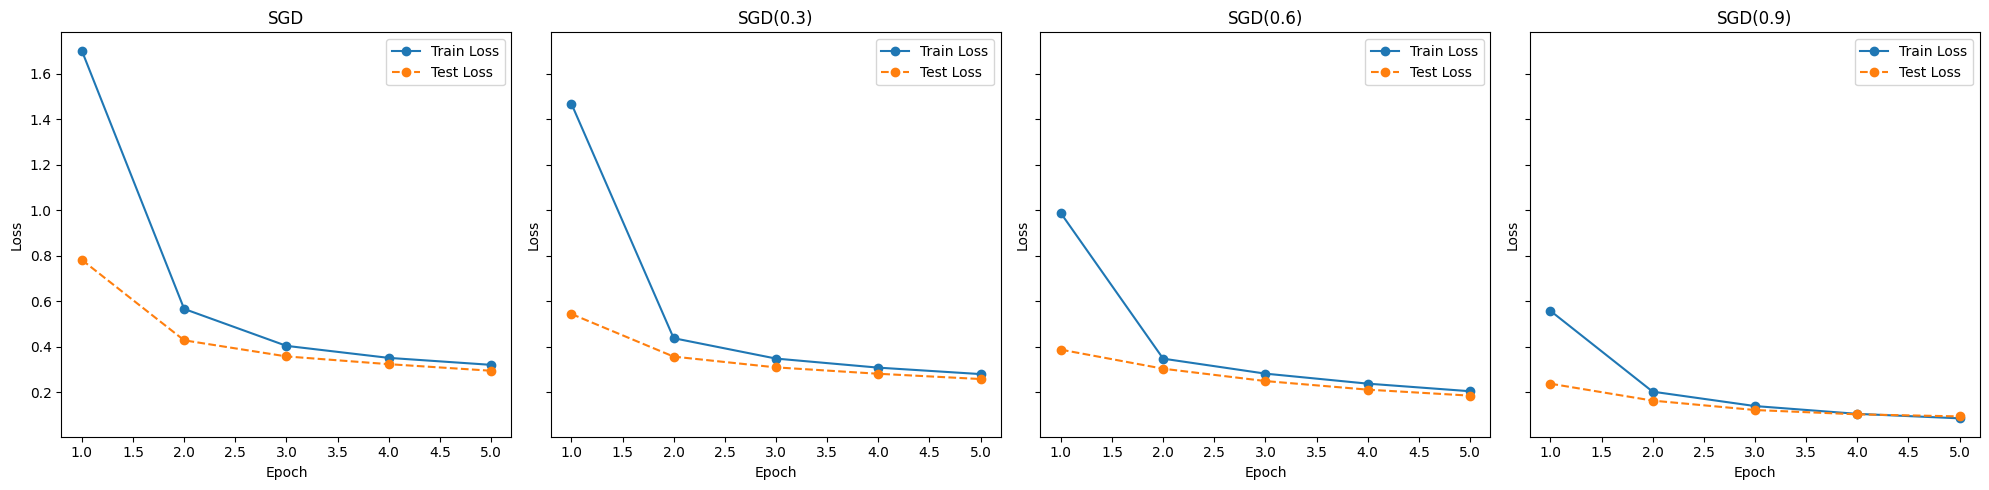

In [12]:
mom_configs = [
    {**default_config, "optimizer_type": "SGD", "label": "SGD"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.3, "label": "SGD(0.3)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.6, "label": "SGD(0.6)"},
    {**default_config, "optimizer_type": "SGD", "momentum": 0.9, "label": "SGD(0.9)"}
]

mom_results = result_handler(mom_configs)
plot_handler(mom_results, mom_configs)